In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
import seaborn as sns

In [3]:
class WellnessRLAgent:
    """
    Reinforcement Learning Agent for Personalized Wellness Application
    Based on the project proposal methodology
    """
    
    def __init__(self, learning_rate=0.1, discount_factor=0.9, 
                 initial_epsilon=0.3, epsilon_decay=0.995, min_epsilon=0.05):
        """
        Initialize RL Agent with Q-learning parameters
        """
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        
        # Q-table: (state, action) -> Q-value
        self.q_table = defaultdict(lambda: defaultdict(float))
        
        # Action space as defined in proposal
        self.actions = {
            0: "Increase Workout Intensity (IWI)",
            1: "Decrease Workout Intensity (DWI)", 
            2: "Increase Meditation Frequency (IMF)",
            3: "Send Motivational Message (SMM)",
            4: "Introduce Journaling Feature (IJF)",
            5: "Maintain Current Plan (MCP)"
        }
        
        # Reward function weights (α=0.5, β=0.3, λ=1.0)
        self.alpha = 0.5  # Engagement weight
        self.beta = 0.3   # Motivation weight
        self.lambda_penalty = 1.0  # Dropout penalty
        
        # Training history
        self.training_history = {
            'episode': [],
            'reward': [],
            'epsilon': [],
            'engagement': [],
            'motivation': []
        }

    def encode_state(self, user_state):
        """
        Convert user state to discrete state representation
        State: [age, gender, BMI, anxiety, activity_week, meditation_week, engagement, segment]
        """
        age_bin = min(int(user_state[0] // 10), 5)  # Age bins: 0-9, 10-19, ..., 50+
        gender = int(user_state[1])
        bmi_bin = min(int((user_state[2] - 15) // 5), 6)  # BMI bins
        anxiety_bin = min(int(user_state[3] // 5), 4)  # Anxiety bins
        activity_bin = min(int(user_state[4]), 7)  # Activity days
        engagement_bin = min(int(user_state[6] * 10), 10)  # Engagement 0-1 -> 0-10
        
        return (age_bin, gender, bmi_bin, anxiety_bin, activity_bin, engagement_bin)

    def calculate_reward(self, next_state):
        """
        Calculate reward based on the reward function from proposal:
        R(s,a) = α·E(s') + β·M(s') - λ·D(s')
        """
        engagement = next_state[6]  # Engagement score [0,1]
        motivation = next_state[7] if len(next_state) > 7 else np.random.uniform(1, 5)  # Motivation [1,5]
        dropout = 1 if engagement < 0.1 else 0  # Dropout if very low engagement
        
        reward = (self.alpha * engagement + 
                 self.beta * (motivation / 5.0) -  # Normalize motivation to [0,1]
                 self.lambda_penalty * dropout)
        
        return reward

    def select_action(self, state):
        """
        ε-greedy action selection
        """
        if np.random.random() < self.epsilon:
            # Exploration: random action
            return np.random.choice(len(self.actions))
        else:
            # Exploitation: best known action
            state_key = self.encode_state(state)
            q_values = [self.q_table[state_key][action] for action in range(len(self.actions))]
            return np.argmax(q_values)

    def update_q_value(self, state, action, reward, next_state):
        """
        Q-learning update rule:
        Q(s,a) ← Q(s,a) + η[r + γ·max_a'Q(s',a') - Q(s,a)]
        """
        state_key = self.encode_state(state)
        next_state_key = self.encode_state(next_state)
        
        # Current Q-value
        current_q = self.q_table[state_key][action]
        
        # Best next Q-value
        next_q_values = [self.q_table[next_state_key][a] for a in range(len(self.actions))]
        max_next_q = max(next_q_values) if next_q_values else 0
        
        # Q-learning update
        new_q = current_q + self.learning_rate * (
            reward + self.discount_factor * max_next_q - current_q
        )
        
        self.q_table[state_key][action] = new_q

    def decay_epsilon(self):
        """
        Decay exploration rate
        """
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)

In [5]:
class WellnessEnvironment:
    """
    Simulated wellness environment for testing RL agent
    """
    
    def __init__(self):
        self.segments = {
            0: "High Anxiety, Low Activity",
            1: "Moderate Anxiety, Moderate Activity", 
            2: "Low Anxiety, High Activity",
            3: "Physical Health Risk",
            4: "Wellness Seekers",
            5: "Inactive, Unengaged"
        }
        
    def generate_user(self):
        """
        Generate a random user state for testing
        State: [age, gender, BMI, anxiety, activity_week, meditation_week, engagement, segment]
        """
        age = np.random.randint(18, 60)
        gender = np.random.choice([0, 1])  # 0: Male, 1: Female
        bmi = np.random.normal(25, 4)
        anxiety = np.random.randint(0, 20)
        activity_week = np.random.randint(0, 7)
        meditation_week = np.random.randint(0, 7)
        engagement = np.random.uniform(0.1, 0.9)
        segment = np.random.choice(6)
        
        return np.array([age, gender, bmi, anxiety, activity_week, 
                        meditation_week, engagement, segment])

    def simulate_user_response(self, state, action):
        """
        Simulate how user responds to different actions
        Returns next_state and reward
        """
        next_state = state.copy()
        
        # Simulate state changes based on action
        if action == 0:  # Increase Workout Intensity
            if state[4] < 6:  # If not already very active
                next_state[4] = min(7, state[4] + 1)
                next_state[6] = min(1.0, state[6] + 0.1)  # Increase engagement
            else:
                next_state[6] = max(0.1, state[6] - 0.2)  # Might decrease if too intense
                
        elif action == 1:  # Decrease Workout Intensity  
            next_state[4] = max(0, state[4] - 1)
            next_state[6] = min(1.0, state[6] + 0.05)  # Slight engagement boost
            
        elif action == 2:  # Increase Meditation Frequency
            next_state[5] = min(7, state[5] + 1)
            next_state[3] = max(0, state[3] - 1)  # Reduce anxiety
            next_state[6] = min(1.0, state[6] + 0.15)
            
        elif action == 3:  # Send Motivational Message
            next_state[6] = min(1.0, state[6] + 0.08)
            
        elif action == 4:  # Introduce Journaling
            next_state[3] = max(0, state[3] - 2)  # Reduce anxiety more
            next_state[6] = min(1.0, state[6] + 0.12)
            
        elif action == 5:  # Maintain Current Plan
            next_state[6] = max(0.1, state[6] - 0.02)  # Slight engagement decay
        
        # Add some noise to make it realistic
        next_state[6] += np.random.normal(0, 0.05)
        next_state[6] = np.clip(next_state[6], 0.1, 1.0)
        
        return next_state

In [7]:
def run_training_simulation(episodes=500):
    """
    Run RL training simulation and collect results
    """
    agent = WellnessRLAgent()
    env = WellnessEnvironment()
    
    print("🏃‍♂️ Starting Wellness RL Training Simulation...")
    print(f"Episodes: {episodes}")
    print(f"Actions: {list(agent.actions.values())}")
    print("-" * 60)
    
    for episode in range(episodes):
        # Generate user
        state = env.generate_user()
        
        # Select action
        action = agent.select_action(state)
        
        # Simulate environment response
        next_state = env.simulate_user_response(state, action)
        
        # Calculate reward
        reward = agent.calculate_reward(next_state)
        
        # Update Q-table
        agent.update_q_value(state, action, reward, next_state)
        
        # Decay epsilon
        agent.decay_epsilon()
        
        # Store training data
        agent.training_history['episode'].append(episode)
        agent.training_history['reward'].append(reward)
        agent.training_history['epsilon'].append(agent.epsilon)
        agent.training_history['engagement'].append(next_state[6])
        agent.training_history['motivation'].append(np.random.uniform(1, 5))  # Simulated
        
        # Print progress
        if episode % 100 == 0:
            avg_reward = np.mean(agent.training_history['reward'][-100:])
            print(f"Episode {episode:3d} | Avg Reward: {avg_reward:.3f} | "
                  f"ε: {agent.epsilon:.3f} | Action: {agent.actions[action][:20]}...")
    
    print(" Training completed!")
    return agent

In [9]:
def demonstrate_learned_policy(agent, env):
    """
    Demonstrate the learned policy on sample users
    """
    print("\n🎯 Demonstrating Learned Policy:")
    print("-" * 60)
    
    # Test on different user segments
    test_users = [
        [25, 1, 28.5, 14, 1, 1, 0.2, 0],  # High Anxiety, Low Activity (from proposal)
        [30, 0, 22.0, 3, 6, 0, 0.8, 2],   # Low Anxiety, High Activity  
        [45, 1, 32.0, 8, 2, 2, 0.3, 3],   # Physical Health Risk
    ]
    
    segment_names = ["High Anxiety, Low Activity", "Low Anxiety, High Activity", "Physical Health Risk"]
    
    for i, user_state in enumerate(test_users):
        print(f"\n👤 User {i+1} ({segment_names[i]}):")
        print(f"   State: Age={user_state[0]}, BMI={user_state[2]:.1f}, "
              f"Anxiety={user_state[3]}, Engagement={user_state[6]:.2f}")
        
        # Get Q-values for all actions
        state_key = agent.encode_state(user_state)
        q_values = {action: agent.q_table[state_key][action] 
                   for action in range(len(agent.actions))}
        
        # Find best action
        best_action = max(q_values, key=q_values.get)
        
        print(f"   🏆 Best Action: {agent.actions[best_action]}")
        print(f"   📊 Q-values: {[(agent.actions[a][:15], f'{q:.3f}') for a, q in q_values.items()]}")

In [11]:
def create_visualizations(agent):
    """
    Create visualization plots for the training results
    """
    plt.style.use('seaborn-v0_8')
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Wellness RL Agent Training Results', fontsize=16, fontweight='bold')
    
    # 1. Reward over time
    axes[0,0].plot(agent.training_history['episode'], 
                   pd.Series(agent.training_history['reward']).rolling(50).mean(),
                   color='#2E86AB', linewidth=2)
    axes[0,0].set_title('Average Reward Over Time')
    axes[0,0].set_xlabel('Episode')
    axes[0,0].set_ylabel('Reward')
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Epsilon decay
    axes[0,1].plot(agent.training_history['episode'], agent.training_history['epsilon'],
                   color='#A23B72', linewidth=2)
    axes[0,1].set_title('Exploration Rate (ε) Decay')
    axes[0,1].set_xlabel('Episode')
    axes[0,1].set_ylabel('Epsilon')
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Engagement distribution
    axes[1,0].hist(agent.training_history['engagement'], bins=30, 
                   color='#F18F01', alpha=0.7, edgecolor='black')
    axes[1,0].set_title('User Engagement Distribution')
    axes[1,0].set_xlabel('Engagement Score')
    axes[1,0].set_ylabel('Frequency')
    axes[1,0].grid(True, alpha=0.3)
    
    # 4. Action frequency heatmap
    action_counts = defaultdict(int)
    for episode in range(len(agent.training_history['episode'])):
        # Simulate action selection for visualization
        dummy_state = [25, 1, 25, 10, 3, 2, 0.5, 1]
        action = agent.select_action(dummy_state) 
        action_counts[action] += 1
    
    # Create action frequency data
    action_names = [agent.actions[i][:15] + '...' for i in range(len(agent.actions))]
    action_freqs = [action_counts[i] for i in range(len(agent.actions))]
    
    bars = axes[1,1].bar(range(len(action_names)), action_freqs, 
                         color=['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#4A5D23', '#8E44AD'])
    axes[1,1].set_title('Action Selection Frequency')
    axes[1,1].set_xlabel('Actions')
    axes[1,1].set_ylabel('Selection Count')
    axes[1,1].set_xticks(range(len(action_names)))
    axes[1,1].set_xticklabels(action_names, rotation=45, ha='right')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Additional Q-table heatmap
    plt.figure(figsize=(12, 8))
    
    # Extract Q-values for visualization
    states = list(agent.q_table.keys())[:20]  # Show first 20 states
    q_matrix = []
    
    for state in states:
        q_row = [agent.q_table[state][action] for action in range(len(agent.actions))]
        q_matrix.append(q_row)
    
    if q_matrix:
        q_matrix = np.array(q_matrix)
        sns.heatmap(q_matrix, 
                    xticklabels=[agent.actions[i][:10] + '...' for i in range(len(agent.actions))],
                    yticklabels=[f'State {i}' for i in range(len(states))],
                    annot=True, fmt='.3f', cmap='viridis')
        plt.title('Q-Values Heatmap (Sample States)')
        plt.xlabel('Actions')
        plt.ylabel('States')
        plt.tight_layout()
        plt.show()

In [13]:
#sample initialization and training run

🌟 Personalized Wellness Application - RL Demo
🏃‍♂️ Starting Wellness RL Training Simulation...
Episodes: 500
Actions: ['Increase Workout Intensity (IWI)', 'Decrease Workout Intensity (DWI)', 'Increase Meditation Frequency (IMF)', 'Send Motivational Message (SMM)', 'Introduce Journaling Feature (IJF)', 'Maintain Current Plan (MCP)']
------------------------------------------------------------
Episode   0 | Avg Reward: 0.394 | ε: 0.298 | Action: Increase Workout Int...
Episode 100 | Avg Reward: 0.448 | ε: 0.181 | Action: Decrease Workout Int...
Episode 200 | Avg Reward: 0.449 | ε: 0.110 | Action: Increase Workout Int...
Episode 300 | Avg Reward: 0.443 | ε: 0.066 | Action: Increase Workout Int...
Episode 400 | Avg Reward: 0.411 | ε: 0.050 | Action: Increase Workout Int...
 Training completed!

🎯 Demonstrating Learned Policy:
------------------------------------------------------------

👤 User 1 (High Anxiety, Low Activity):
   State: Age=25, BMI=28.5, Anxiety=14, Engagement=0.20
   🏆 Best

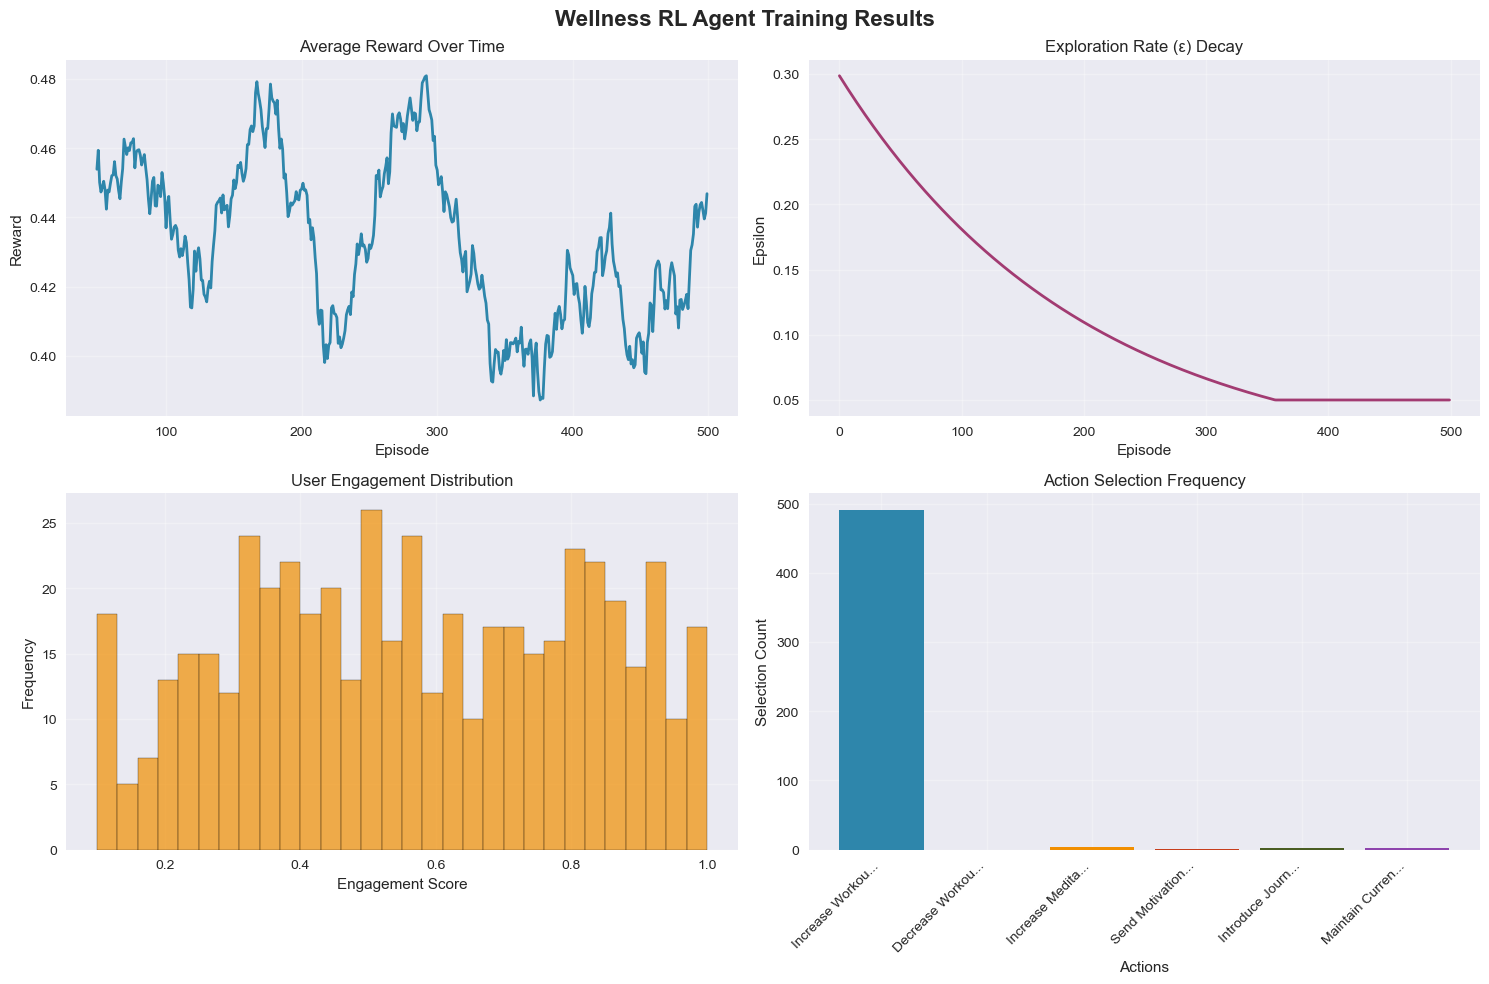

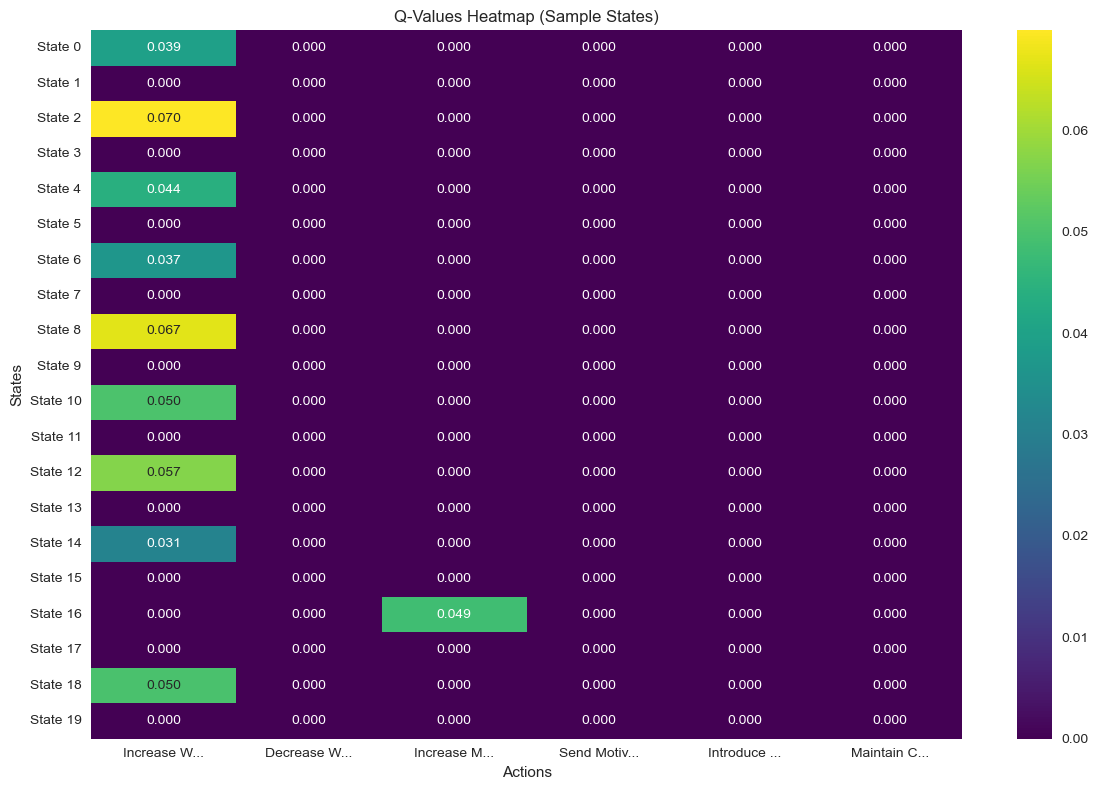

In [17]:
print("🌟 Personalized Wellness Application - RL Demo")
print("=" * 60)
    
    # Run training simulation
trained_agent = run_training_simulation(episodes=500)
    
    # Create environment for demonstration
env = WellnessEnvironment()
    
    # Demonstrate learned policy
demonstrate_learned_policy(trained_agent, env)
    
    # Create visualizations
print("\n📊 Generating visualizations...")
create_visualizations(trained_agent)
    
